In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse
from sklearn.datasets import make_moons


### Usando k-means

In [2]:
# Gerar dados 
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,cluster_std=0.60, random_state=0)

/home/elaine/anaconda_puc/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


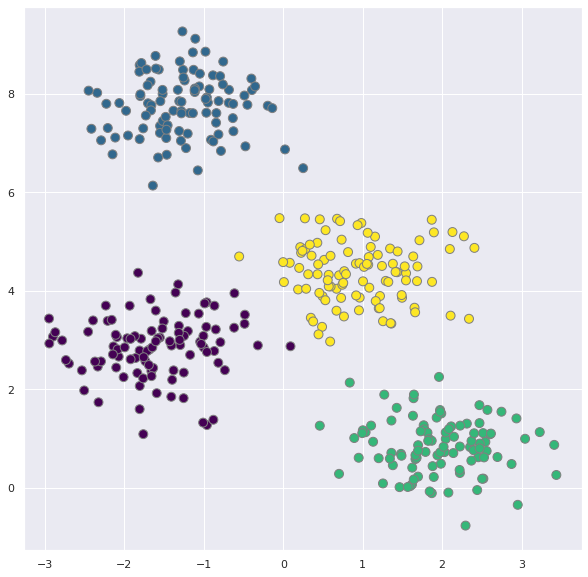

In [3]:
# Plotar dados com os labels do K-means
plt.figure(figsize=(10,10))
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=80, cmap='viridis', edgecolors='gray');

In [4]:
#criar função de plotar
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    
    plt.figure(figsize=(10,10))

    #fit e predict no X
    labels = kmeans.fit_predict(X)

    # plota os dados de entrada
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=80, cmap='viridis', zorder=2, edgecolors='gray')

    # plota a representação do modelo KMeans
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

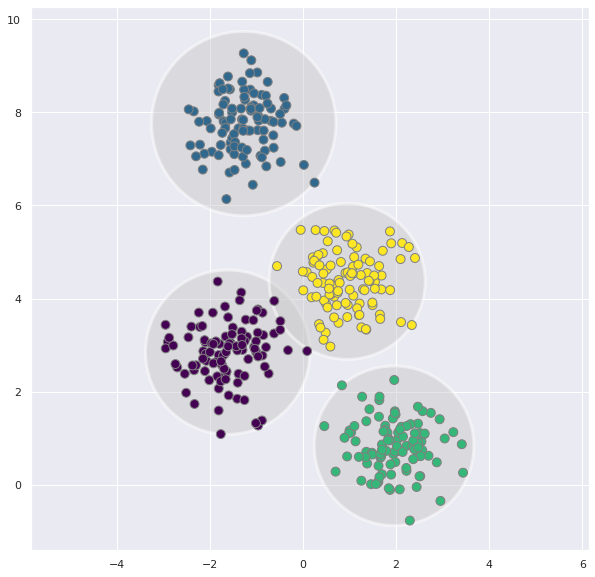

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)


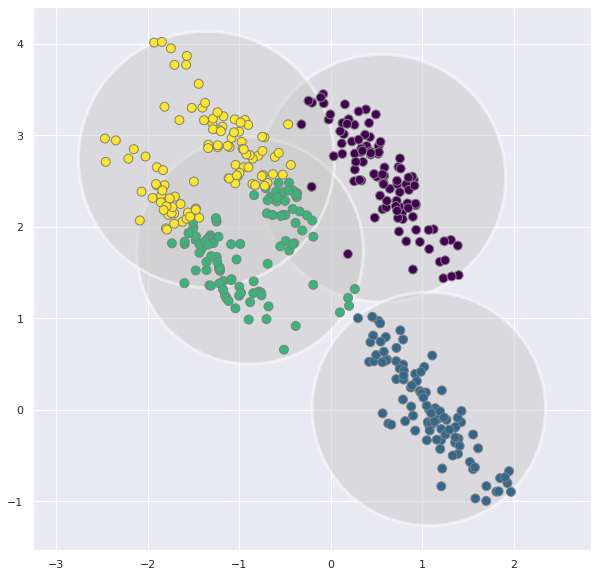

In [6]:
#se transformar os dados para formato elíptico
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

### Gaussian Mixture Models

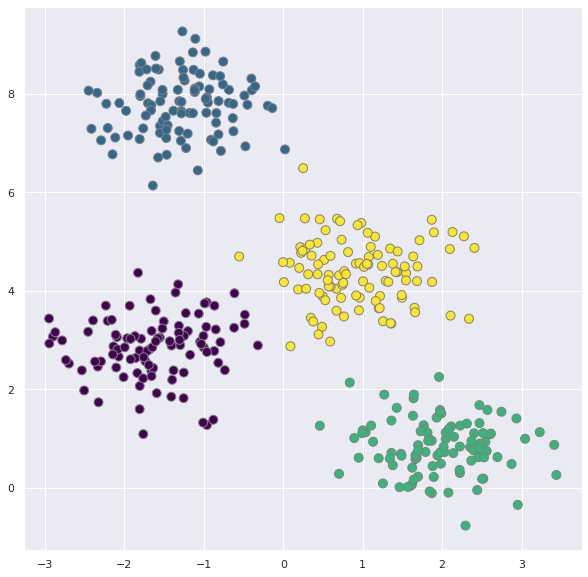

In [7]:
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.figure(figsize=(10,10))

plt.scatter(X[:, 0], X[:, 1], c=labels, s=80, cmap='viridis', edgecolors='gray');



In [8]:
#probabilidades 
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


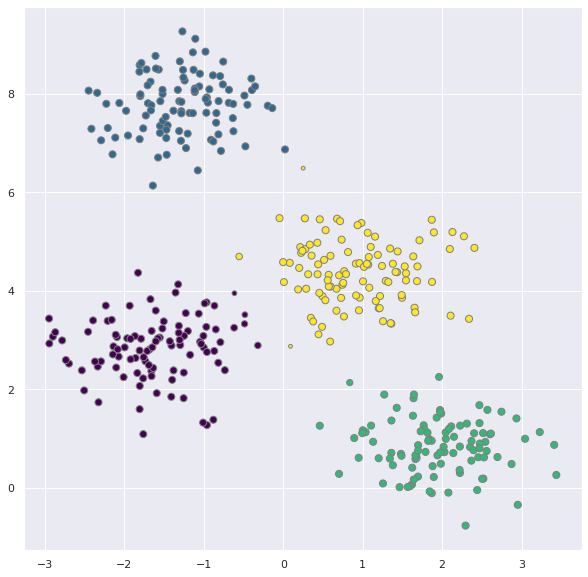

In [9]:
#mudar o tamanho do ponto de acordo com a probabilidade dada
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size, edgecolors='gray');


In [10]:
#função para desenhar elipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Converter covariancia para o axes principal
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Desenha a elipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    #plota resultado do algoritmo gmm
    ax = ax or plt.gca()
    #fit e predict
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, edgecolors='gray')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

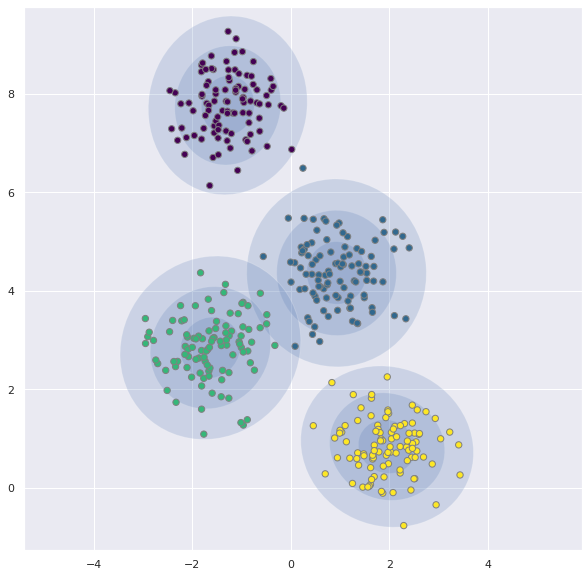

In [11]:
gmm = GMM(n_components=4, random_state=42)
plt.figure(figsize=(10,10))
plot_gmm(gmm, X)

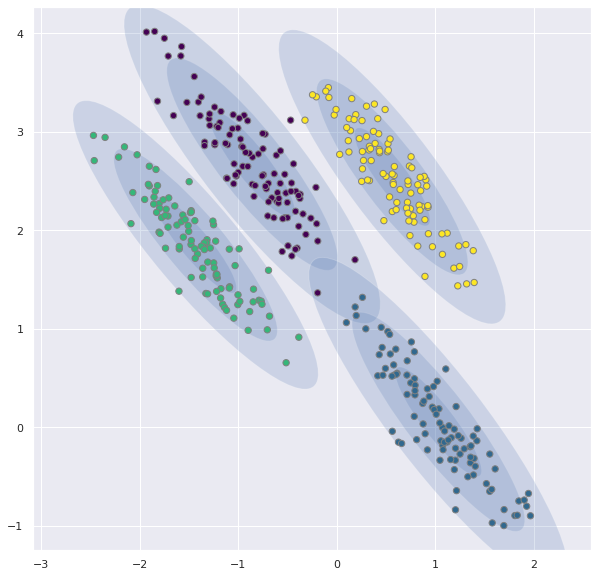

In [12]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plt.figure(figsize=(10,10))
plot_gmm(gmm, X_stretched)

### Estimação de densidade com GMM

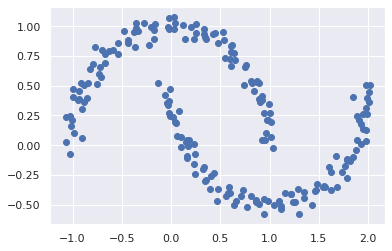

In [13]:
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

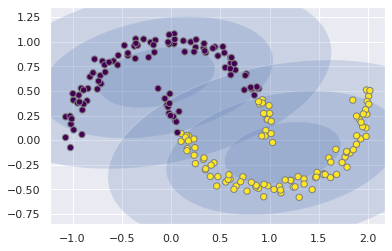

In [14]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)


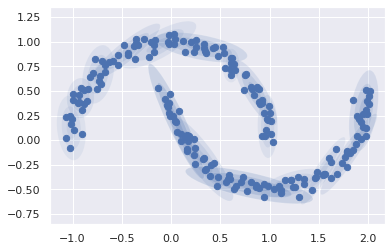

In [15]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Text(0.5, 0, 'n_components')

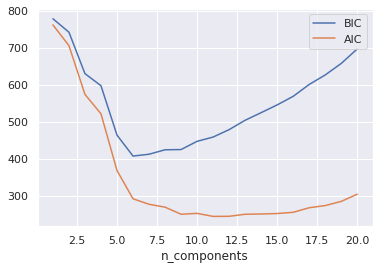

In [20]:
# Akaike information criterion (AIC) o
# Bayesian information criterion (BIC)
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

### Gerando novos dados com GMM

In [16]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA        


In [17]:
digits = load_digits()
digits.data.shape

(1797, 64)

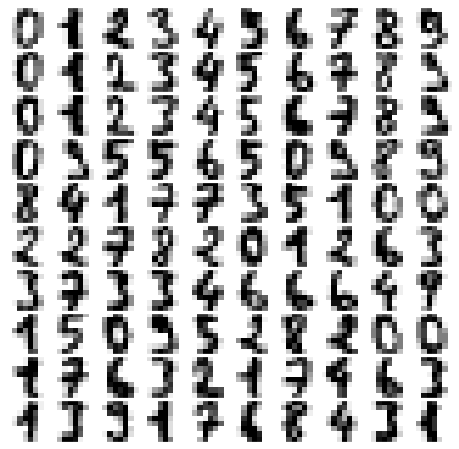

In [18]:
#Definir função de plotar dados
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [19]:
#considerando 99% da variabilidade dos dados
pca = PCA(0.99, whiten=True)       
data = pca.fit_transform(digits.data)        
data.shape

(1797, 41)

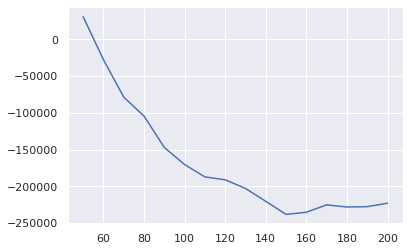

In [21]:
#verificando o melhor valor de componentes
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [22]:
#treinando com melhor valor 
gmm = GMM(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [23]:
#criando amostra de dados a partir do modelo treinado
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

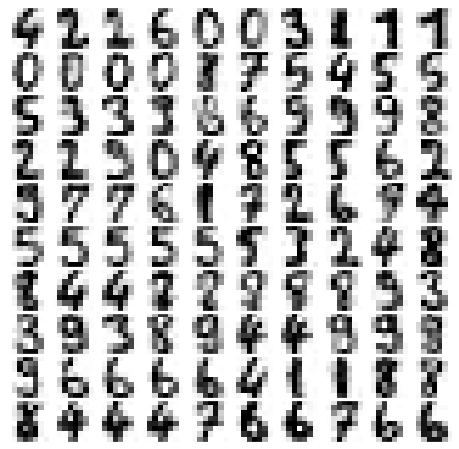

In [24]:
#dados gerados
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)